In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils import AverageMeter, accuracy
from torchvision import datasets
import torchvision.transforms as transforms
import os
from models import model_dict

In [2]:
def evaluation(model, test_loader):
    model.eval()   # 将模型设置为评估模式，不会进行参数更新
    acc_recorder = AverageMeter()  # 初始化一个用于记录准确度的工具

    with torch.no_grad():
        for img, label in test_loader:
            if torch.cuda.is_available():
                model = model.cuda()
                img = img.cuda()
                label = label.cuda()
            out = model(img)  # 使用模型进行推理，获取输出
            acc = accuracy(out, label)[0]    # 计算准确度并更新记录器
            acc_recorder.update(acc.item(), img.size(0))
    acces = acc_recorder.avg    # 计算平均准确度
    return acces


In [3]:
transform_test = transforms.Compose([transforms.Resize([224, 224]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.3738, 0.3738, 0.3738),
                                                            (0.3240, 0.3240, 0.3240))])
testset = datasets.ImageFolder(root=os.path.join("new_COVID_19_Radiography_Dataset", 'test'),
                                transform=transform_test)
test_loader = DataLoader(testset, batch_size=128, num_workers=4,shuffle=False, pin_memory=True)

In [4]:
dataset = "new_COVID_19_Radiography_Dataset"
seed = 33
model = model_dict["resnet18"](num_classes=4)
mpath = 'report/{}/{}/seed{}/ckpt/best.pth'.format(dataset, "resnet18", seed)  
checkpoint = torch.load(mpath)  # 加载模型权重
model.load_state_dict(checkpoint['model'])   # 加载模型的权重参数
# 推理法1：
acc = evaluation(model, test_loader)
print(f"Accuracy on test set: {acc:.2f}%")

Accuracy on test set: 78.43%


In [5]:
# 推理法2：
correct = 0  # 初始化正确预测的样本数量
total = 0  # 初始化测试集总样本数量

# 开启模型评估模式
model.eval()

# 禁止梯度计算
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)  # 进行模型推理，得到预测结果
        _, predicted = torch.max(outputs, 1)  # 获取预测结果中概率最高的类别索引
        total += labels.size(0)  # 更新测试集总样本数量
        correct += (predicted == labels).sum().item()  # 更新正确预测的样本数量

# 计算模型在测试集上的准确度
accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 78.43%


Predicted Class: Viral Pneumonia


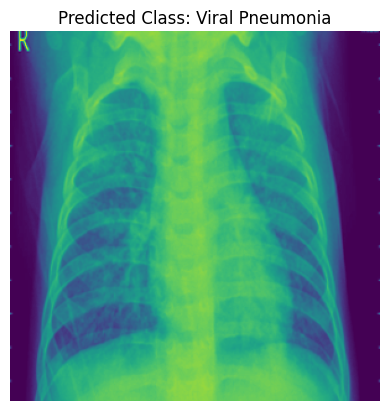

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 加载已经训练好的模型
model_path = r"report\new_COVID_19_Radiography_Dataset\resnet18\seed33\ckpt\best.pth"
model_checkpoint = torch.load(model_path)
model_name = "resnet18"  # 模型名称
num_classes = 4  # 类别数
model = model_dict[model_name](num_classes=num_classes)  # 创建模型实例
model.load_state_dict(model_checkpoint['model'])  # 加载模型权重
model.eval()  # 设置模型为评估模式

# 定义图像预处理的转换
transform = transforms.Compose([
    transforms.Resize([224, 224]),  # 调整图像大小为 224x224 像素
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize((0.3738, 0.3738, 0.3738), (0.3240, 0.3240, 0.3240))  # 标准化图像
])

# 定义类别标签
class_names = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# 图像分类推理函数
def predict_image(image_path):
    # 加载图像并进行预处理
    image = Image.open(image_path)
    image = image.convert("RGB")  # 将图像转换为 RGB 彩色图
    image = transform(image)  # 转换图像为张量形状
    image = image.unsqueeze(0)  # 添加一个维度，变成形状为 [1, 3, 224, 224] 的张量
    
    # 在推理过程中，使用 torch.no_grad() 上下文管理器，以停止梯度计算，因为在推理时不需要计算梯度。
    # 将图像输入模型，获取模型的输出
    with torch.no_grad():
        outputs = model(image)  # 将图像传递给模型进行推理，得到输出
        _, predicted = torch.max(outputs, 1)  # 从输出中获取预测类别
        class_idx = predicted.item()  # 获取预测类别的索引
        class_label = class_names[class_idx]  # 根据索引获取预测类别的标签
    # 返回预测的类别标签
    return class_label

# 加载并预测图像
image_path = r"new_COVID_19_Radiography_Dataset\test\Viral Pneumonia\images\Viral Pneumonia-100.png" # 可以换其他类别的数据集
predicted_class = predict_image(image_path)
print("Predicted Class:", predicted_class)

# 可视化图像
image = Image.open(image_path)
plt.imshow(image)
plt.title("Predicted Class: " + predicted_class)
plt.axis("off")
plt.show()
